# 書き込み誤差検討
## 反対に磁化

In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
%env TOKEN=*************************************
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

env: TOKEN=*************************************
Cloning into 'MOD2NN'...
remote: Enumerating objects: 1406, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 1406 (delta 91), reused 123 (delta 60), pack-reused 1235
Receiving objects: 100% (1406/1406), 40.95 MiB | 6.77 MiB/s, done.
Resolving deltas: 100% (796/796), done.
Mounted at /content/drive


In [3]:
import sys
import re
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats

from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer
from Faraday.two_dim import matplotlib_style
matplotlib_style.paper()

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
model_path = "/content/drive/MyDrive/D2NN/trained_model/20220824/l1_0.000000e+00/seed_1"
model = tf.keras.models.load_model(model_path)
eval = model.evaluate(x_test, y_test)

313/313 [==============================] - 8s 13ms/step - loss: 0.4724 - accuracy: 0.8684


In [5]:
pattern = r'mo'

mo_layers = []
bi_weights = []
error_weights = []

for layer in model.layers:
  result = re.match(pattern, layer.name)
  if result:
      mo_layers.append(layer)
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
      bi_weights.append(bi_w)

In [ ]:
seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
acc_table = np.zeros((len(seeds), len(p)))
loss_table = np.zeros((len(seeds), len(p)))

for j, _p in enumerate(p):
  for k, seed in enumerate(seeds):
    for i, layer in enumerate(mo_layers):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100)) * 2 - 1
        w = layer.get_weights()
        w[0] = bi_weights[i] * bi_dist
        layer.set_weights(w)

    bi_eval = model.evaluate(x_test, y_test)
    acc_table[k, j] = bi_eval[1]
    loss_table[k, j] = bi_eval[0]

313/313 [==============================] - 4s 13ms/step - loss: 0.6414 - accuracy: 0.8106


In [ ]:
acc_df = pd.DataFrame(acc_table, columns=["{:.1f}".format(t) for t in p])
loss_df = pd.DataFrame(loss_table, columns=["{:.1f}".format(t)  for t in p])

In [ ]:
acc_df.to_csv("acc.csv")
loss_df.to_csv("loss.csv")

In [33]:
acc_df = pd.read_csv("acc.csv", index_col=0)
loss_df = pd.read_csv("loss.csv", index_col=0)

In [34]:
float(acc_df.columns[0])

0.0

In [1]:
ave = np.average(acc_df.values, axis=0)
for i in range(acc_df.shape[1]):
    x = np.ones_like(acc_df.values[:,i]) * float(acc_df.columns[i])
    y = acc_df.values[:,i]
    plt.scatter(x, y, label=r"$p={:.1f}$".format(float(acc_df.columns[i])))

plt.plot([float(_p) for _p in acc_df.columns], ave, label="Average", color="black")
plt.ylim(0., 1.)
plt.ylabel("Accuracy")
plt.xlabel("$p$")
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2
#plt.legend()
plt.savefig("out/fig2.png", dpi=300)

NameError: name 'np' is not defined

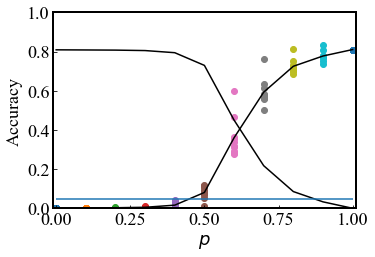

In [36]:
ave = np.average(acc_df.values, axis=0)
for i in range(acc_df.shape[1]):
    x = np.ones_like(acc_df.values[:,i]) * float(acc_df.columns[i])
    y = acc_df.values[:,i]
    plt.scatter(x, y, label=r"$p={:.1f}$".format(float(acc_df.columns[i])))

plt.plot([float(_p) for _p in acc_df.columns], ave, label="average", color="black")
plt.plot([float(_p) for _p in acc_df.columns], ave[-1]-ave, label="average", color="black")
plt.hlines(0.05, 0,1)
plt.ylim(0., 1.)
plt.ylabel("Accuracy")
plt.xlabel("$p$")
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2
#plt.legend()
plt.savefig("out/fig2.png", dpi=300)

## 消磁

In [6]:
seeds = np.arange(1, 11)
p = np.arange(0, 1.1, 0.1)
acc_table = np.zeros((len(seeds), len(p)))
loss_table = np.zeros((len(seeds), len(p)))

for j, _p in enumerate(p):
  for k, seed in enumerate(seeds):
    for i, layer in enumerate(mo_layers):
        np.random.seed(seed)
        bi_dist = stats.bernoulli.rvs(p=_p, size=(100,100))
        w = layer.get_weights()
        w[0] = bi_weights[i] * bi_dist
        layer.set_weights(w)

    bi_eval = model.evaluate(x_test, y_test)
    acc_table[k, j] = bi_eval[1]
    loss_table[k, j] = bi_eval[0]

313/313 [==============================] - 4s 13ms/step - loss: 0.5537 - accuracy: 0.8356


In [7]:
acc_df = pd.DataFrame(acc_table, columns=["{:.1f}".format(t) for t in p])
loss_df = pd.DataFrame(loss_table, columns=["{:.1f}".format(t)  for t in p])

In [8]:
acc_df.to_csv("acc_demag.csv")
loss_df.to_csv("loss_demag.csv")

In [28]:
acc_df = pd.read_csv("acc_demag.csv", index_col=0)
loss_df = pd.read_csv("loss_demag.csv", index_col=0)

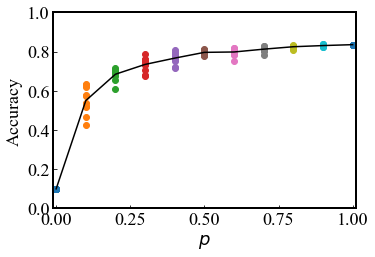

In [29]:
ave = np.average(acc_df.values, axis=0)
for i in range(acc_df.shape[1]):
    x = np.ones_like(acc_df.values[:,i]) * float(acc_df.columns[i])
    y = acc_df.values[:,i]
    plt.scatter(x, y, label=r"$p={:.1f}$".format(float(acc_df.columns[i])))

plt.plot([float(_p) for _p in acc_df.columns], ave, label="average", color="black")
plt.ylim(0., 1.)
plt.ylabel("Accuracy")
plt.xlabel("$p$")
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2
#plt.legend()
plt.savefig("out/fig.png", dpi=300)

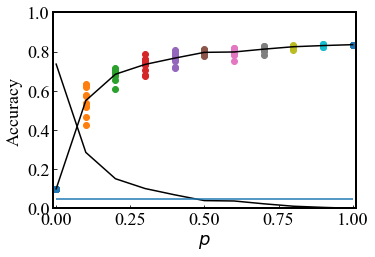

In [32]:
ave = np.average(acc_df.values, axis=0)
for i in range(acc_df.shape[1]):
    x = np.ones_like(acc_df.values[:,i]) * float(acc_df.columns[i])
    y = acc_df.values[:,i]
    plt.scatter(x, y, label=r"$p={:.1f}$".format(float(acc_df.columns[i])))

plt.plot([float(_p) for _p in acc_df.columns], ave, label="average", color="black")
plt.plot([float(_p) for _p in acc_df.columns], ave[-1]-ave, label="average", color="black")
plt.hlines(0.05, 0,1)
plt.ylim(0., 1.)
plt.ylabel("Accuracy")
plt.xlabel("$p$")
plt.rcParams['figure.subplot.bottom'] = 0.2
plt.rcParams['figure.subplot.left'] = 0.2
#plt.legend()
plt.savefig("out/fig2.png", dpi=300)